In [1]:
from langchain.tools import tool
import requests
from langchain.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()
WEATHER_API_KEY = os.getenv("WEATHER_API_KEY")

In [3]:
@tool
def get_weather( query : str ) -> list :
    """This tool interacts with weatherapi to get current weather"""
    api_endpoint = f"http://api.weatherapi.com/v1/current.json?key={WEATHER_API_KEY}&q={query}"
    response = requests.get( api_endpoint )
    data = response.json()
    if data.get("location"):
        return data
    else:
        return "Location not found"
    
@tool
def web_search(query : str) -> list :
    """This tool allows to search queries on web"""
    search = TavilySearchResults(max_results=2 , search_depth="advanced" )
    results = search.invoke(query)
    return results

tools = [ get_weather , web_search ]


In [ ]:
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI( model = "gemini-2.0-flash" ,)
bind_llm = llm.bind_tools(tools=tools )

In [13]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import START , END , StateGraph , MessagesState

In [14]:
tool_node = ToolNode( tools = tools )

def invoke_model( state : MessagesState ):
    print("\nInvoking model....................")
    messages = state["messages"]
    print(f"Messages : \n{messages}")
    response = bind_llm.invoke( messages )
    print(f"Response : \n{response}")
    return { "messages" : [response] }

def invoke_tools( state : MessagesState ):
    print("\nInvoking Tools.....................")
    messages = state["messages"]
    print(f"Messages : \n{messages}")
    last_message = messages[-1]
    print(f"Last Message : \n{last_message}")
    if last_message.tool_calls:
        print(f"\ntools : \n{last_message.tool_calls}")
        return "tools"
    return END


In [15]:
workflow = StateGraph( MessagesState )
workflow.add_node( "LLM" , invoke_model )
workflow.add_edge( START , "LLM" )
workflow.add_node( "tools" , tool_node )
workflow.add_conditional_edges( "LLM" , invoke_tools )
workflow.add_edge( "tools" , "LLM" )

agent = workflow.compile()


In [16]:
for chunk in agent.stream({"messages":[("user","What is the current weather in chennai?")]} , stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What is the current weather in chennai?

Invoking model....................
Messages : 
[HumanMessage(content='What is the current weather in chennai?', additional_kwargs={}, response_metadata={}, id='b6b64521-7ea7-4644-ba7c-9e0f5f2410f0')]
Response : 
content='' additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"query": "chennai"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-d6976fc5-0e82-4c31-9e3c-acb8d25d2fbb-0' tool_calls=[{'name': 'get_weather', 'args': {'query': 'chennai'}, 'id': 'f6d3c798-8b1d-4cc0-a65c-4435f6bd2230', 'type': 'tool_call'}] usage_metadata={'input_tokens': 37, 'output_tokens': 6, 'total_tokens': 43, 'input_token_details': {'cache_read': 0}}

Invoking Tools.....................
Messages : 
[HumanMessage(content='What is the current weather in chennai?', additional_kwa

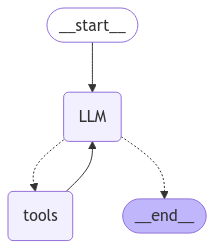

In [18]:
from IPython.display import Image

Image(agent.get_graph().draw_mermaid_png())
